### QueryToReference mapping

Here we will use human pancreas datasets (scRNA-seq data) of different studies as an example to illustrate how Garfield performs QueryToreference process.

In [1]:
import os
os.chdir('/data2/zhouwg_data/project/Garfield')
os.getcwd()

'/data2/zhouwg_data/project/Garfield'

In [2]:
# load packages
import warnings
import Garfield as gf
import scanpy as sc

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

gf.__version__

'0.3.1'

In [3]:
## load data
adata = sc.read_h5ad('/home/zhouweige/zhouwg_data/project/Garfield_tutorials/data/panc8.h5ad')
adata

AnnData object with n_obs × n_vars = 14890 × 34363
    obs: 'ClusterID', 'ClusterName', 'batch', 'celltype', 'nCount_RNA'
    var: 'Selected', 'vst_mean', 'vst_variable', 'vst_variance', 'vst_variance_expected', 'vst_variance_standardized'
    obsm: 'pca_cell_embeddings', 'umap_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'counts', 'norm_data', 'scale_data'

In [4]:
# Ensure adata.X is counts.
adata.X.max()

1453667.0

In [5]:
# check the batch information of this dataset
adata.obs['batch'].value_counts()

batch
indrop        8569
smartseq2     2394
celseq2       2285
celseq        1004
fluidigmc1     638
Name: count, dtype: int64

### split all_adata into reference dataset and query dataset

In [6]:
adata_ref = adata[~adata.obs['batch'].isin(['smartseq2', 'celseq2']),:]
adata_ref

View of AnnData object with n_obs × n_vars = 10211 × 34363
    obs: 'ClusterID', 'ClusterName', 'batch', 'celltype', 'nCount_RNA'
    var: 'Selected', 'vst_mean', 'vst_variable', 'vst_variance', 'vst_variance_expected', 'vst_variance_standardized'
    obsm: 'pca_cell_embeddings', 'umap_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'counts', 'norm_data', 'scale_data'

In [7]:
# Inspect the batches contained in the dataset.
adata_ref.obs.batch.value_counts()

batch
indrop        8569
celseq        1004
fluidigmc1     638
Name: count, dtype: int64

In [8]:
adata_query = adata[adata.obs['batch'].isin(['smartseq2', 'celseq2']),:]
adata_query

View of AnnData object with n_obs × n_vars = 4679 × 34363
    obs: 'ClusterID', 'ClusterName', 'batch', 'celltype', 'nCount_RNA'
    var: 'Selected', 'vst_mean', 'vst_variable', 'vst_variance', 'vst_variance_expected', 'vst_variance_standardized'
    obsm: 'pca_cell_embeddings', 'umap_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'counts', 'norm_data', 'scale_data'

In [9]:
# Inspect the batches contained in the dataset.
adata_query.obs.batch.value_counts()

batch
smartseq2    2394
celseq2      2285
Name: count, dtype: int64

## Integrating reference data using Garfield

For reference integration of scRNAseq data, we should adjust the following paremeters, and all parameter introductions can be found in [Garfield_Model_Parameters](https://github.com/zhou-1314/Garfield/blob/main/Garfield_Model_Parameters.md).

In [10]:
# set workdir
workdir = '/home/zhouweige/zhouwg_data/project/Garfield_tutorials/result/garfield_QueryToRef_panc' 
gf.settings.set_workdir(workdir)

### modify parameter
user_config = dict(
    ## Input options
    adata_list=adata, 
    profile='RNA',   # if it is 'ATAC' or 'ADT', please adjust it.
    sample_col='batch',  # Specify columns for batch

    ## Preprocessing options
    used_hvg=True,
    min_cells=3,
    min_features=0,
    keep_mt=False,
    target_sum=1e4,
    rna_n_top_features=3000,
    atac_n_top_features=None, # if data belongs to 'ATAC', please specify it.
    n_components=50,
    n_neighbors=5,
    metric='euclidean',  # STR     Metric for clustering.                   Default is `euclidean`.
    svd_solver='arpack',
    # datasets
    adj_key='connectivities',
    
    # data split parameters
    edge_val_ratio=0.1,
    edge_test_ratio=0.,
    node_val_ratio=0.1,
    node_test_ratio=0.,

    ## Model options
    augment_type='svd',
    svd_q=5,
    use_FCencoder=False,
    conv_type='GATv2Conv', # GAT or GATv2Conv or GCN
    gnn_layer=2,
    hidden_dims=[128, 128],
    bottle_neck_neurons=20,
    cluster_num=20,
    drop_feature_rate=0.2, 
    drop_edge_rate=0.2,
    num_heads=3,
    dropout=0.2,
    concat=True,
    used_edge_weight=False,
    used_DSBN=False,
    used_mmd=True,
    # data loader parameters
    num_neighbors=5,
    loaders_n_hops=2,
    edge_batch_size=4096,
    node_batch_size=128, # None
    # loss parameters
    include_edge_recon_loss=False,
    include_gene_expr_recon_loss=True,
    lambda_latent_contrastive_instanceloss=1.0,
    lambda_latent_contrastive_clusterloss=0.5,
    lambda_gene_expr_recon=500., # To make the model more focused on learning expression features, increase this parameter.
    lambda_edge_recon=100., # To make the model more focused on learning Adjacency graph features, increase this parameter.
    lambda_omics_recon_mmd_loss=3., # If the integration is not strong enough, increase it.
    # train parameters
    n_epochs_no_edge_recon=0,
    learning_rate=0.001,
    weight_decay=1e-05,
    gradient_clipping=5,
    # other parameters
    latent_key='garfield_latent',
    reload_best_model=True,
    use_early_stopping=True,
    early_stopping_kwargs=None,
    monitor=True,
    seed=2024,
    verbose=True
)
dict_config = gf.settings.set_gf_params(user_config)

Saving results in: /home/zhouweige/zhouwg_data/project/Garfield_tutorials/result/garfield_QueryToRef_panc


In [11]:
from Garfield.model import Garfield

# Initialize model
model = Garfield(dict_config)

--- DATA LOADING AND PREPROCESSING ---
COSINE SIM GRAPH DECODER -> dropout_rate: 0.2


In [12]:
# Train model
model.train()


--- INITIALIZING TRAINER ---
Number of training nodes: 13401
Number of validation nodes: 1489
Number of training edges: 41904
Number of validation edges: 4655
Edge batch size: 4096
Node batch size: 128

--- MODEL TRAINING ---
Epoch 1/100 |--------------------| 1.0% val_auroc_score: 0.8981; val_auprc_score: 0.8834; val_best_acc_score: 0.7988; val_best_f1_score: 0.8153; train_kl_reg_loss: 25.6854; train_edge_recon_loss: 70.5568; train_gene_expr_recon_loss: 71812.6950; train_lambda_latent_contrastive_instanceloss: 7.1768; train_lambda_latent_contrastive_clusterloss: 3.6995; train_gene_expr_mmd_loss: 8140.0272; train_global_loss: 79989.2841; train_optim_loss: 79989.2841; val_kl_reg_loss: 19.7598; val_edge_recon_loss: 76.5443; val_gene_expr_recon_loss: 61161.8887; val_lambda_latent_contrastive_instanceloss: 7.0860; val_lambda_latent_contrastive_clusterloss: 3.6555; val_gene_expr_mmd_loss: 10097.2271; val_global_loss: 71289.6172; val_optim_loss: 71289.6172
Epoch 2/100 |--------------------|

In [13]:
# Compute latent neighbor graph
latent_key = 'garfield_latent'
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)
# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

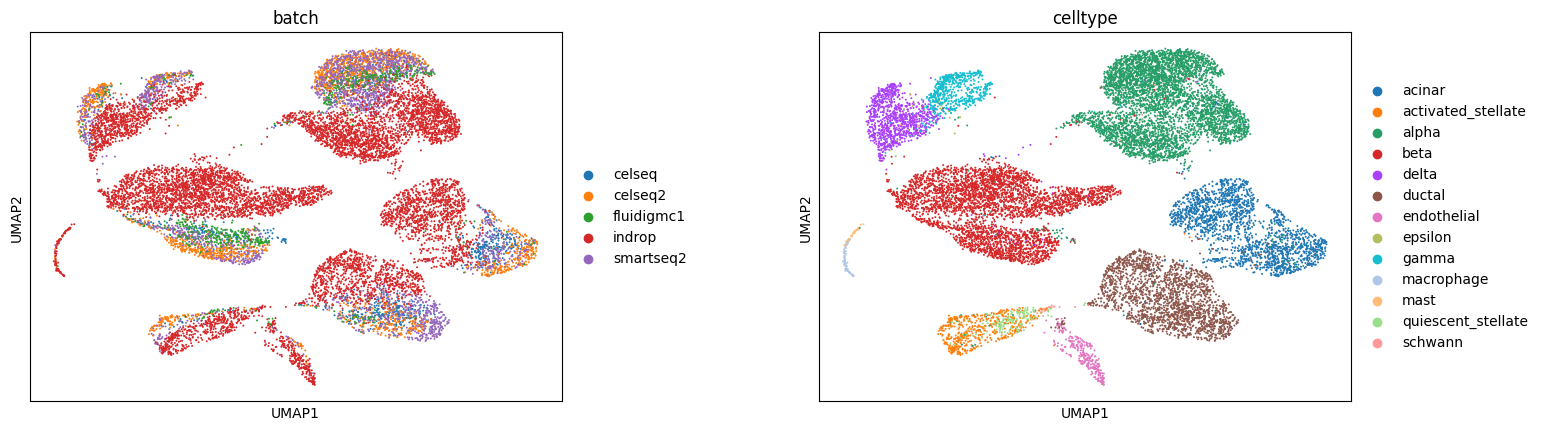

In [14]:
sc.pl.umap(model.adata, color=['batch', 'celltype'], wspace=0.35, edges=False)

In [15]:
# Save trained model
model_folder_path = f"{workdir}/model"
os.makedirs(model_folder_path, exist_ok=True)

model.save(dir_path=model_folder_path,
           overwrite=True,
           save_adata=True,
           adata_file_name="adata_ref.h5ad")

## Perform surgery on reference model and fine-tune on query dataset

In [16]:
# load_query_data
new_model = model.load_query_data(dir_path=model_folder_path,
                                      query_adata=adata_query,
                                      ref_adata_name="adata_ref.h5ad",
                                      use_cuda=True,
                                      unfreeze_all_weights=False,
                                      unfreeze_eps_weight=True,
                                      unfreeze_layer0=True,
                                      used_mmd=True)
# Training and obtain latent representation
new_model.train()

Query data contains expression data of  31363  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 4679 × 3000
    obs: 'ClusterID', 'ClusterName', 'batch', 'celltype', 'nCount_RNA'
    var: 'Selected', 'vst_mean', 'vst_variable', 'vst_variance', 'vst_variance_expected', 'vst_variance_standardized'
    obsm: 'pca_cell_embeddings', 'umap_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'counts', 'norm_data', 'scale_data'
--- DATA LOADING AND PREPROCESSING ---
COSINE SIM GRAPH DECODER -> dropout_rate: 0.2

--- INITIALIZING TRAINER ---
Number of training nodes: 17612
Number of validation nodes: 1957
Number of training edges: 50931
Number of validation edges: 5659
Edge batch size: 4096
Node batch size: 128

--- MODEL TRAINING ---
Epoch 1/100 |--------------------| 1.0% val_auroc_score: 0.9716; val_auprc_score: 0.9644; val_best_acc_score: 0.8465; val_best

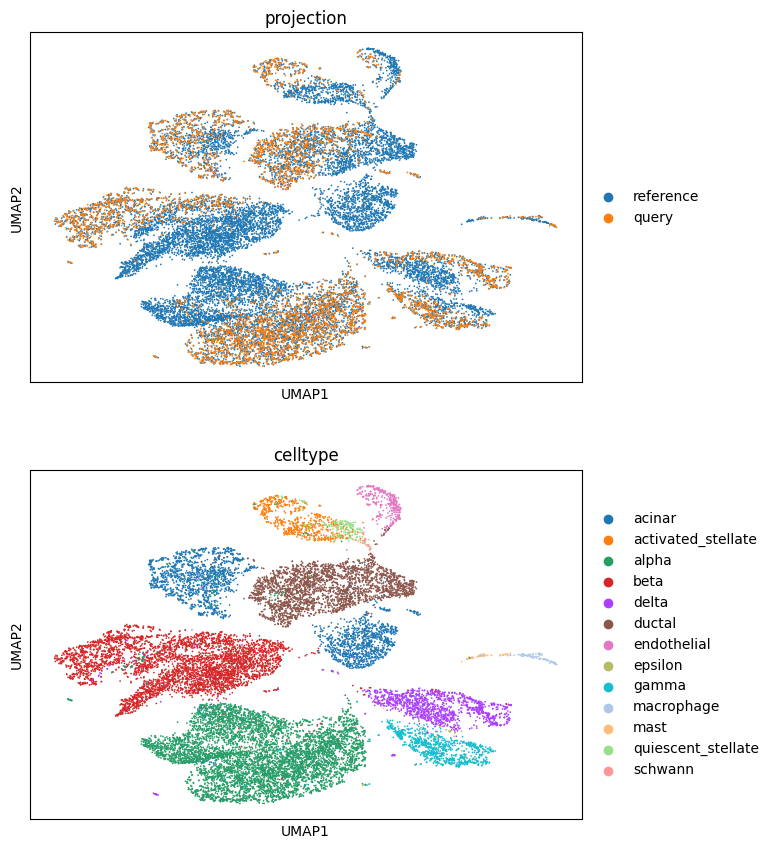

In [17]:
# plot UMAP
sc.pp.neighbors(new_model.adata, use_rep='garfield_latent')
sc.tl.umap(new_model.adata)
sc.pl.umap(new_model.adata, color=['projection', 'celltype'],
           ncols=1, wspace=0.20, edges=False)

In [18]:
## split
adata_ref = new_model.adata[new_model.adata.obs['projection'] == 'reference', :]
adata_query = new_model.adata[new_model.adata.obs['projection'] == 'query', :]

## Label transfer

In [19]:
### Label transfer
## major celltype
adata_query = new_model.label_transfer(ref_adata=adata_ref,
                                       ref_adata_emb='garfield_latent',
                                       query_adata=adata_query,
                                       query_adata_emb='garfield_latent',
                                       n_neighbors=10,
                                       ref_adata_obs=adata_ref.obs,
                                       label_keys='celltype')
adata_query

Weighted KNN with n_neighbors = 10 ... 
Label transfer finished!


AnnData object with n_obs × n_vars = 4679 × 3000
    obs: 'ClusterID', 'ClusterName', 'batch', 'celltype', 'nCount_RNA', 'n_genes', 'projection', 'transferred_celltype_unfiltered', 'transferred_celltype_uncert'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'projection_colors', 'celltype_colors'
    obsm: 'X_pca', 'X_umap', 'feat', 'garfield_latent', 'pca_cell_embeddings', 'umap_cell_embeddings'
    varm: 'PCs'
    layers: 'counts', 'norm_data', 'scale_data'
    obsp: 'distances', 'connectivities'

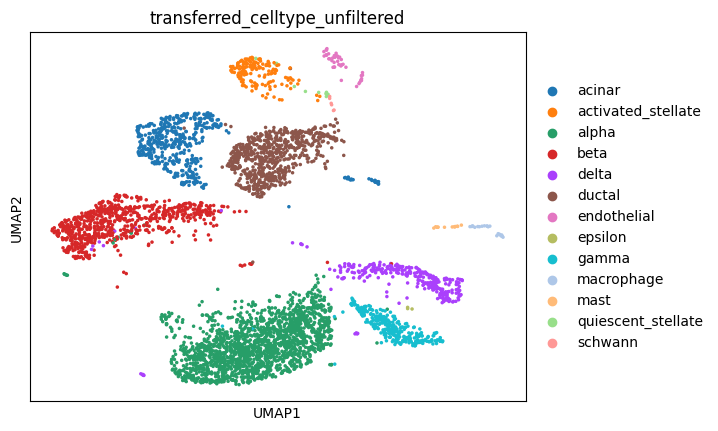

In [20]:
## predicted label
sc.pl.umap(adata_query,color=['transferred_celltype_unfiltered'])

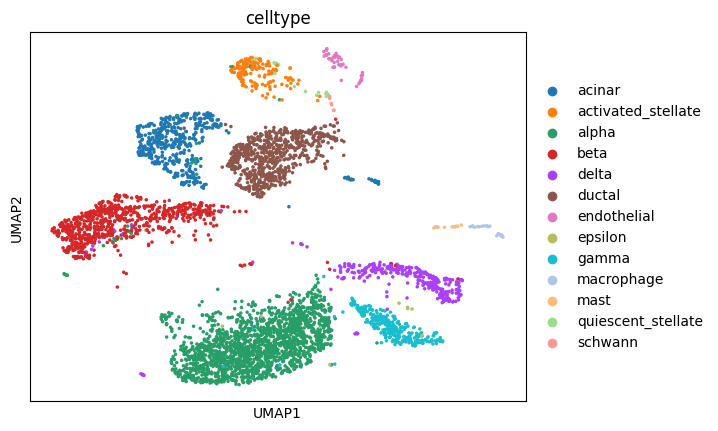

In [21]:
## real label
sc.pl.umap(adata_query,color=['celltype'])

In [22]:
import pandas as pd
pd.crosstab(adata_query.obs.celltype, adata_query.obs.transferred_celltype_unfiltered)

transferred_celltype_unfiltered,acinar,activated_stellate,alpha,beta,delta,ductal,endothelial,epsilon,gamma,macrophage,mast,quiescent_stellate,schwann
celltype,,,,,,,,,,,,,
acinar,461,0,0,0,0,1,0,0,0,0,0,0,0
activated_stellate,0,145,0,0,0,0,0,0,0,0,0,0,0
alpha,12,6,1822,11,1,0,0,0,0,0,0,0,0
beta,1,0,2,746,3,1,0,0,0,0,0,0,0
delta,0,0,4,7,318,1,0,0,0,0,0,0,0
ductal,1,0,2,2,0,696,0,0,0,0,0,0,0
endothelial,0,0,0,0,0,0,42,0,0,0,0,0,0
epsilon,0,0,2,1,2,0,0,3,4,0,0,0,0
gamma,0,0,5,0,0,0,0,0,318,0,0,0,0


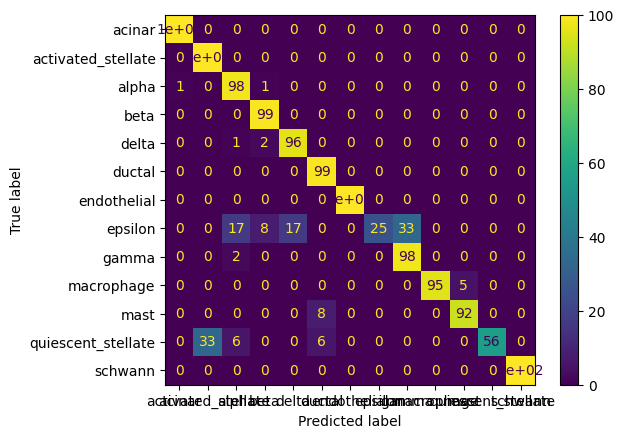

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

cm = confusion_matrix(adata_query.obs.celltype, adata_query.obs.transferred_celltype_unfiltered)
ConfusionMatrixDisplay(
    confusion_matrix=np.round((cm.T/np.sum(cm, axis=1)).T*100),
    display_labels=np.unique(adata_query.obs.celltype)
).plot()

In [24]:
# Save trained model
model.save(dir_path=model_folder_path,
           overwrite=True,
           save_adata=True,
           adata_file_name="adata_concat.h5ad")